# Single Family Temperature Scan and Overlap Analysis

This notebook performs two main tasks:
1.  **Temperature Optimization**: Scans temperatures for each gene family (PF00004 and PF00041) in isolation to find the temperature where simulated energies best match natural energies.
2.  **Overlap Analysis**: Uses the optimal temperatures to simulate overlapping genes across a range of overlap lengths and visualizes the energy distribution.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os

# Add current directory to path to import overlappingGenes
sys.path.append(os.getcwd())
import overlappingGenes as og

In [2]:
# ==========================================
# PARAMETERS SECTION
# ==========================================

# Paths
PF00004_PARAMS_PATH = "PF00004/PF00004_params.dat"
PF00004_NATURAL_ENERGIES_PATH = "PF00004/PF00004_naturalenergies.txt"

PF00041_PARAMS_PATH = "PF00041/PF00041_params.dat"
PF00041_NATURAL_ENERGIES_PATH = "PF00041/PF00041_naturalenergies.txt"

# Simulation Parameters
NUM_ITERATIONS = 100000 # Adjust as needed for speed vs accuracy
NUM_TRIALS_TEMP_SCAN = 100
NUM_TRIALS_OVERLAP_SCAN = 10

# Temperature Scan Ranges
TEMP_RANGE_PF00004 = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]
TEMP_RANGE_PF00041 = [0.8, 0.9, 0.93, 1.0, 1.1, 1.2]

# Overlap Scan Range
OVERLAP_RANGE = range(10, 101, 5)

# High Temperature for Isolation (to randomize the other gene)
HIGH_TEMP = 1000.0

In [3]:
# ==========================================
# DATA LOADING
# ==========================================

def load_family_data(params_path, energies_path):
    print(f"Loading parameters from {params_path}...")
    J, h = og.extract_params(params_path)
    print(f"Loading natural energies from {energies_path}...")
    natural_energies = og.load_natural_energies(energies_path)
    return J, h, natural_energies

# Load Data
print("Loading PF00004 Data...")
J1, h1, nat_E1 = load_family_data(PF00004_PARAMS_PATH, PF00004_NATURAL_ENERGIES_PATH)
print("Loading PF00041 Data...")
J2, h2, nat_E2 = load_family_data(PF00041_PARAMS_PATH, PF00041_NATURAL_ENERGIES_PATH)

print("Data loaded successfully.")


# Calculate Statistics for Convergence Check
mean_e1 = np.mean(nat_E1)
std_e1 = np.std(nat_E1)
mean_e2 = np.mean(nat_E2)
std_e2 = np.std(nat_E2)

print(f"PF00004 Stats: Mean={mean_e1:.2f}, Std={std_e1:.2f}")
print(f"PF00041 Stats: Mean={mean_e2:.2f}, Std={std_e2:.2f}")


Loading PF00004 Data...
Loading parameters from PF00004/PF00004_params.dat...
Loading natural energies from PF00004/PF00004_naturalenergies.txt...
Loading PF00041 Data...
Loading parameters from PF00041/PF00041_params.dat...
Loading natural energies from PF00041/PF00041_naturalenergies.txt...
Data loaded successfully.
PF00004 Stats: Mean=145.88, Std=38.25
PF00041 Stats: Mean=120.66, Std=17.64


In [ ]:
# ==========================================
# HELPER FUNCTIONS FOR TEMP SCAN
# ==========================================

def run_temp_scan(target_family_idx, temp_range, J1, h1, J2, h2, natural_energies, num_trials=NUM_TRIALS_TEMP_SCAN):
    """
    Runs simulation for a range of temperatures for the target family,
    while keeping the other family at a very high temperature (HIGH_TEMP).
    
    target_family_idx: 1 for PF00004, 2 for PF00041
    """
    results = {}
    
    # Determine lengths for initial sequence generation
    L1 = h1.shape[0]
    L2 = h2.shape[0]
    # Use a fixed overlap for scanning (e.g., small or medium)
    scan_overlap = 10 
    
    # Calculate stats for convergence (we need to pass them even if ignored)
    # We can just use the passed natural energies for the target, and dummy for other
    mean_target = np.mean(natural_energies)
    std_target = np.std(natural_energies)
    
    print(f"Starting Temperature Scan for Family {target_family_idx}...")
    
    for T in temp_range:
        print(f"  Testing T = {T}...", end="", flush=True)
        energies = []
        
        for i in range(num_trials):
            # Generate random initial sequence
            init_seq = og.initial_seq_no_stops(L1, L2, scan_overlap, quiet=True)
            
            # Set temperatures based on target
            if target_family_idx == 1:
                T1_val = T
                T2_val = HIGH_TEMP
                check_e1 = True
                check_e2 = False
            else:
                T1_val = HIGH_TEMP
                T2_val = T
                check_e1 = False
                check_e2 = True
            
            # Run Simulation
            # Note: We pass dummy stats for the ignored family, it doesn't matter
            _, _, e1_final, e2_final = og.overlapped_sequence_generator_convergence(
                (J1, h1), (J2, h2), init_seq,
                mean_e1=mean_target if target_family_idx==1 else 0,
                std_e1=std_target if target_family_idx==1 else 1,
                mean_e2=mean_target if target_family_idx==2 else 0,
                std_e2=std_target if target_family_idx==2 else 1,
                max_iterations=NUM_ITERATIONS,
                T1=T1_val, T2=T2_val,
                check_e1=check_e1, check_e2=check_e2
            )
            
            if target_family_idx == 1:
                energies.append(e1_final)
            else:
                energies.append(e2_final)
                
        results[T] = energies
        print(" Done.")
        
    return results

def plot_histogram_comparison(results, natural_energies, family_name):
    """
    Plots histograms of simulated energies at different temperatures
    overlaid with the natural energy distribution.
    """
    num_temps = len(results)
    cols = 3
    rows = int(np.ceil(num_temps / cols))
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 4*rows), sharex=True)
    axes = axes.flatten()
    
    # Natural energy stats
    nat_mean = np.mean(natural_energies)
    nat_std = np.std(natural_energies)
    
    for i, (T, energies) in enumerate(results.items()):
        ax = axes[i]
        
        # Plot Natural
        ax.hist(natural_energies, bins=30, alpha=0.5, label='Natural', density=True, color='gray')
        
        # Plot Simulated
        ax.hist(energies, bins=30, alpha=0.5, label=f'Sim T={T}', density=True, color='blue')
        
        # Add lines for mean
        ax.axvline(nat_mean, color='k', linestyle='--', label='Nat Mean')
        ax.axvline(np.mean(energies), color='b', linestyle='--', label='Sim Mean')
        
        ax.set_title(f"{family_name} at T={T}")
        ax.legend(fontsize='small')
    
    # Hide unused subplots
    for j in range(i+1, len(axes)):
        axes[j].axis('off')
        
    plt.tight_layout()
    plt.show()


In [ ]:
# ==========================================
# PHASE 1: TEMPERATURE SCANNING
# ==========================================

# Scan PF00004
print("Scanning PF00004...")
results_pf00004 = run_temp_scan(1, TEMP_RANGE_PF00004, J1, h1, J2, h2, nat_E1)
plot_histogram_comparison(results_pf00004, nat_E1, "PF00004")

In [ ]:
# Scan PF00041
print("Scanning PF00041...")
results_pf00041 = run_temp_scan(2, TEMP_RANGE_PF00041, J1, h1, J2, h2, nat_E2)
plot_histogram_comparison(results_pf00041, nat_E2, "PF00041")

## Phase 2: Overlap Scanning

Based on the histograms above, set the optimal temperatures below and run the overlap scan.

In [4]:
# ==========================================
# OPTIMAL TEMPERATURES (SET THESE AFTER PHASE 1)
# ==========================================
OPTIMAL_T1 = 0.8 # REPLACE WITH FOUND OPTIMAL
OPTIMAL_T2 = 0.93 # REPLACE WITH FOUND OPTIMAL

print(f"Using Optimal Temperatures: T1={OPTIMAL_T1}, T2={OPTIMAL_T2}")

Using Optimal Temperatures: T1=0.8, T2=0.93


Starting Overlap Scan (Optimized)...
  Testing Overlap = 10............. Done.
  Testing Overlap = 15............. Done.
  Testing Overlap = 20............. Done.
  Testing Overlap = 25............. Done.
  Testing Overlap = 30............. Done.
  Testing Overlap = 35............. Done.
  Testing Overlap = 40............. Done.
  Testing Overlap = 45............. Done.
  Testing Overlap = 50............. Done.
  Testing Overlap = 55............. Done.
  Testing Overlap = 60............. Done.
  Testing Overlap = 65............. Done.
  Testing Overlap = 70............. Done.
  Testing Overlap = 75............. Done.
  Testing Overlap = 80............. Done.
  Testing Overlap = 85............. Done.
  Testing Overlap = 90............. Done.
  Testing Overlap = 95............. Done.
  Testing Overlap = 100............. Done.


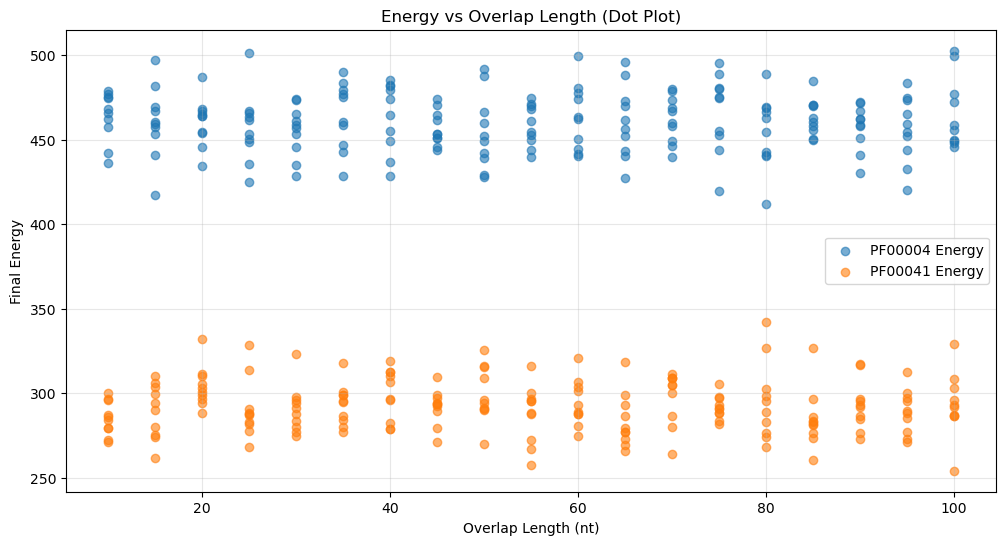

In [ ]:
def run_overlap_scan(overlap_range, T1, T2, J1, h1, J2, h2, num_trials=NUM_TRIALS_OVERLAP_SCAN):
    overlap_results = {
        'overlap': [],
        'E1': [],
        'E2': []
    }
    
    L1 = h1.shape[0]
    L2 = h2.shape[0]
    
    print("Starting Overlap Scan...")
    
    for ov in overlap_range:
        print(f"  Testing Overlap = {ov}...", end="", flush=True)
        for i in range(num_trials):
            init_seq = og.initial_seq_no_stops(L1, L2, ov, quiet=True)
            
            # Use convergence generator
            iterations, converged, final_E1, final_E2 = og.overlapped_sequence_generator_convergence(
                (J1, h1), 
                (J2, h2), 
                init_seq,
                mean_e1=mean_e1, std_e1=std_e1,
                mean_e2=mean_e2, std_e2=std_e2,
                max_iterations=NUM_ITERATIONS,
                T1=T1, 
                T2=T2
            )
            
            overlap_results['overlap'].append(ov)
            overlap_results['E1'].append(final_E1)
            overlap_results['E2'].append(final_E2)
            print(".", end="", flush=True)
        print(" Done.")
            
    return pd.DataFrame(overlap_results)

# Run Scan
df_results = run_overlap_scan(OVERLAP_RANGE, OPTIMAL_T1, OPTIMAL_T2, J1, h1, J2, h2)

# Plot Dot Plot
plt.figure(figsize=(12, 6))
plt.scatter(df_results['overlap'], df_results['E1'], label='PF00004 Energy', alpha=0.6)
plt.scatter(df_results['overlap'], df_results['E2'], label='PF00041 Energy', alpha=0.6)
plt.xlabel('Overlap Length (nt)')
plt.ylabel('Final Energy')
plt.title('Energy vs Overlap Length (Dot Plot)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()